In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import numpy as np
import matplotlib.pyplot as plt
import random

# 普通kmeans

## 产生测试数据

In [3]:
# 中心点
X1,Y1=1,1
X2,Y2=5,3
X3,Y3=2,5
x1 = np.random.normal(X1, 1, 200)
y1 = np.random.normal(Y1, 1, 200)
x2 = np.random.normal(X2, 1, 200)
y2 = np.random.normal(Y2, 1, 200)
x3 = np.random.normal(X3, 1, 200)
y3 = np.random.normal(Y3, 1, 200)

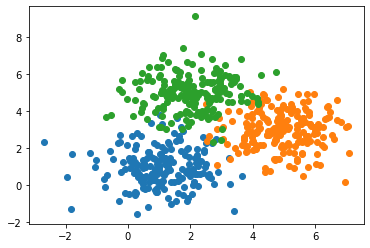

In [4]:
plt.scatter(x1,y1)
plt.scatter(x2,y2)
plt.scatter(x3,y3)

In [5]:
dataset1 = [[x1[i],y1[i]] for i in range(200)]
dataset2 = [[x2[i],y2[i]] for i in range(200)]
dataset3 = [[x3[i],y3[i]] for i in range(200)]
dataset1 = np.array(dataset1)
dataset2 = np.array(dataset2)
dataset3 = np.array(dataset3)

dataset=np.append(dataset1,dataset2,axis=0)
dataset=np.append(dataset,dataset3,axis=0)

## 普通kmeans函数

In [6]:
# 计算欧氏距离
def euclid(point1,point2,dimension):
    dis=0
    for i in range(dimension):
        dis+=(point1[i]-point2[i])**2
    return dis**0.5
# 更新centers
def update_centers(dataset,labels,clusters):
    length,dimension = dataset.shape
    centers=np.zeros([clusters,dimension])
    # 计算每个cluster的个数
    numbers=np.zeros(clusters)
    for label in labels:
        numbers[label]+=1
    for i,point in enumerate(dataset):
        for di in range(dimension):          
            centers[labels[i]][di]+=point[di]
    for i in range(clusters):
        # print(centers[i])
        # print(numbers[i])
        if(numbers[i]!=0):
            centers[i]/=numbers[i]
    return centers
# 可视化
def pplot(dataset,labels):  
    x = dataset[:,0]
    y = dataset[:,1]
    color_list=[ '#000080', '#006400','#00CED1', '#800000', '#800080',
                 '#CD5C5C', '#DAA520', '#E6E6FA', '#F08080', '#FFE4C4']
    cmap = [color_list[i] for i in labels]
    plt.scatter(x,y,c=cmap)

In [7]:
# 参数为数据集、簇个数、迭代次数
def k_means(dataset,clusters,iters,visualization=False,reduced_data=[]):
    plt.ion()
    # 样本个数
    length,dimension = dataset.shape
    # 随机生成初始簇心
    centers = dataset[random.sample(range(0,length),clusters)]
    #print(centers.shape) # clusters*dimension
    # 数据标签,代表每类所属于的簇
    labels = []
    for _ in range(iters):
        for center in centers:
            tmp_list = [euclid(dataset[i],center,dimension) for i in range(length)]
            labels.append(tmp_list)
        labels = np.argmin(labels,axis=0)
        centers = update_centers(dataset,labels,clusters)
        # 分布可视化
        if visualization:
            pplot(reduced_data,labels)
        plt.pause(1)
        if(_!=iters-1):
            labels = []
    plt.ioff()
    return labels

## 普通kmeans测试

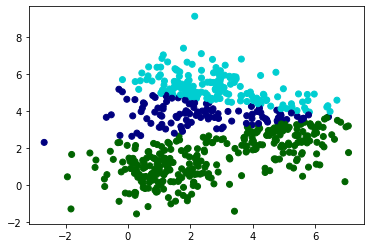

In [8]:
# 测试一下效果
labels=k_means(dataset,3,1,visualization=True,reduced_data=dataset)

# 二分kmeans+层次聚类

## 计算sse（簇内误差平方和）

In [9]:
# 计算sse（簇内误差平方和）
def sse(dataset,labels,clusters):
    length,dimension = dataset.shape
    data = []
    if(clusters>1):
        for i in range(clusters):
            data.append([])
        for i,dt in enumerate(dataset):
            data[labels[i]].append(dt)
    else:
        data.append([])
        data[0] = dataset
    res=0
    for k in range(clusters):
        for point1 in data[k]:
            for point2 in data[k]:
                res+=euclid(point1,point2,dimension)**2
    return res
#sse(dataset,labels,3)

## 二分kmeans

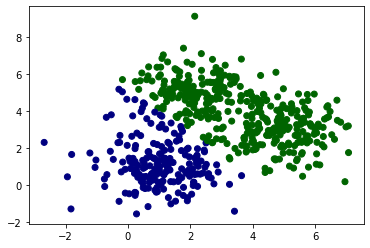

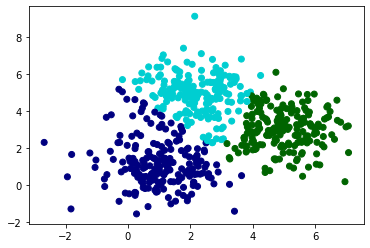

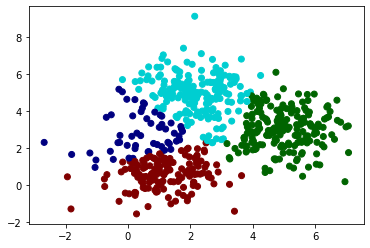

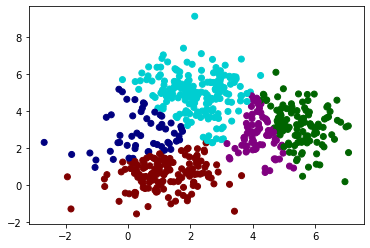

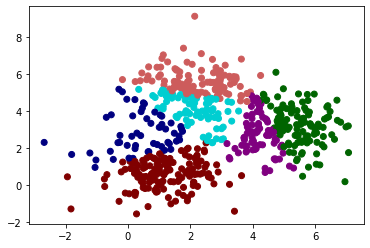

In [10]:
# 二分kmeans,iters代表每次尝试不同点进行二分的次数
def bi_kmeans(dataset,iters,clusters):    
    length = len(dataset)
    # 初始化标签
    labels=[]
    for i in range(length):
        labels.append(0)
    # 分割簇数-1次
    for it in range(clusters-1): 
        # 计算每类sse    
        data = []
        for i in range(it+1):
            data.append([])
        for i,dt in enumerate(dataset):
            data[labels[i]].append(dt) 
        max_sse=0
        tag=0
        for i in range(it+1):
            dt = np.array(data[i])
            tmp_sse = sse(dt,[],1)
            if tmp_sse>max_sse:
                max_sse=tmp_sse
                tag=i
        idx=[]
        for i in range(length):
            if labels[i]==tag:
                idx.append(i)
        dataset_to_divide = data[tag]
        dataset_to_divide = np.array(dataset_to_divide)
        f_labels = k_means(dataset_to_divide,2,1,visualization=False,reduced_data=dataset)
        f_sse = sse(dataset_to_divide,f_labels,2)
        for i in range(iters-1):
            tmp_labels = k_means(dataset_to_divide,2,1,visualization=False,reduced_data=dataset_to_divide)
            tmp_sse = sse(dataset_to_divide,tmp_labels,2)
            if tmp_sse<f_sse:
                f_sse=tmp_sse
                f_labels=tmp_labels
        for i,idxx in enumerate(idx):
            if f_labels[i]==0:
                labels[idxx]=it+1
        pplot(dataset,labels)
    return labels
     
labels=bi_kmeans(dataset,3,6) #每次二分迭代5次，最终分为8个簇

## 使用层次聚类优化2分kmeans

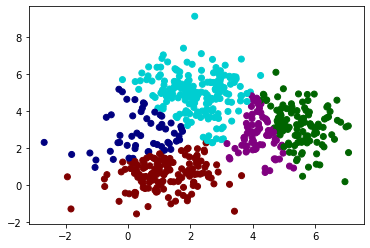

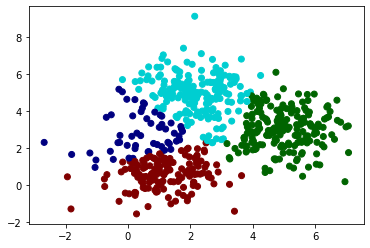

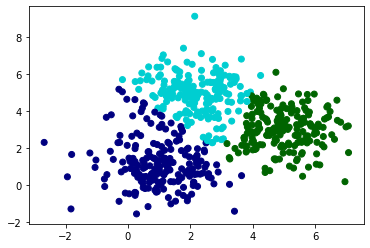

In [11]:
# 计算两个簇之间的平均距离
def average_distance(data1,data2):
    #print(data1.shape)
    _,dimension = data1.shape
    len1=len(data1)
    len2=len(data2)
    ssum=0;
    for i in range(len1):
        for j in range(len2):
            ssum+=euclid(data1[i],data2[j],dimension)
    #print(ssum,len1,len2)
    return ssum/(len1*len2)

# 层次聚类,每次将距离（使用平均距离）最小的两个簇合二为一
def hac(dataset,labels,clusters,target_clusters):
    if target_clusters>=clusters:
        return labels
    for it in range(clusters-target_clusters):
        # 找距离最短的两个簇   
        data = []
        for i in range(clusters-it):
            data.append([])
        for i,dt in enumerate(dataset):
            data[labels[i]].append(dt) 
        min_dis=1e10 #inf
        label1=0
        label2=0
        for i in range(clusters-it):
            for j in range(clusters-it):
                tmp_dis=average_distance(np.array(data[i]),np.array(data[j]))
                if(tmp_dis<min_dis and i!=j):
                    min_dis=tmp_dis
                    label1=i
                    label2=j
        label1,label2=max(label1,label2),min(label1,label2)
        #print(label1,label2)
        for i in range(len(labels)):
            if labels[i]==label1:
                labels[i]=label2
        for i in range(len(labels)):
            if labels[i]>label1:
                labels[i]-=1
        pplot(dataset,labels)
        plt.show()
    return labels
tmp_labels=list(labels)
_=hac(dataset,tmp_labels,6,3)

# 使用手写数字Mnist数据集

##### len(dataset)

In [12]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import argparse
import numpy as np

torch.manual_seed(1)    # 随机种子

# Hyper Parameters
parser = argparse.ArgumentParser(description='Training a model')
parser.add_argument('--batch_size', type=int, default=50, help='')
parser.add_argument('--epoch', type=int, default=2, help='')
parser.add_argument('--lr', type=float, default=0.001, help='')
opt =parser.parse_args(args=[])

DOWNLOAD_MNIST=False
# 下载训练集
train_data = torchvision.datasets.MNIST(
    root='./mnist/',    
    train=True, 
    transform=torchvision.transforms.ToTensor(),   
    download=DOWNLOAD_MNIST,  
)
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)

# bacth_size=50
train_loader = Data.DataLoader(dataset=train_data, batch_size=opt.batch_size, shuffle=True)

# 取前2000个作为测试集
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:1000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:1000]

# 展平数据
data=test_x.detach().numpy()
data=np.squeeze(data,1)
data=data.reshape(1000,28*28)
# 标准化
data = scale(data)

# 使用主成分分析降维

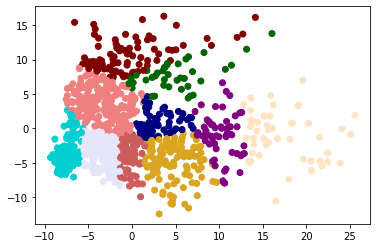

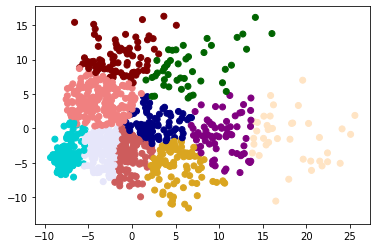

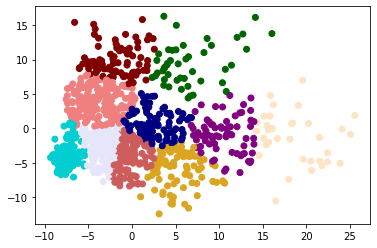

In [13]:
# 使用主成分分析降维
reduced_data = PCA(n_components=2).fit_transform(data)
labels=k_means(reduced_data,10,3,True,reduced_data)

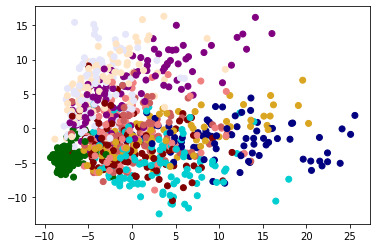

In [14]:
# 用真实数字标签看看效果咋样
pplot(reduced_data,test_y)

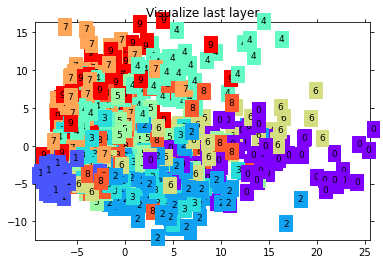

In [15]:
from matplotlib import cm
# 数字绘制
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)
plot_with_labels(reduced_data,test_y.detach().numpy())

# 使用tsne降维

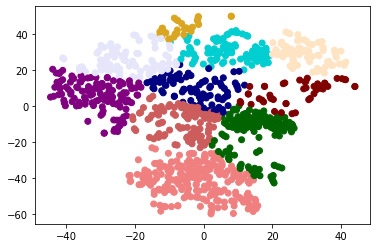

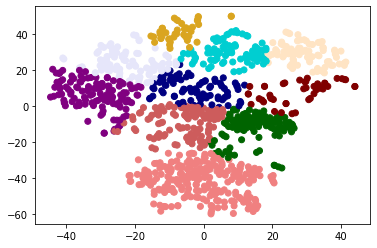

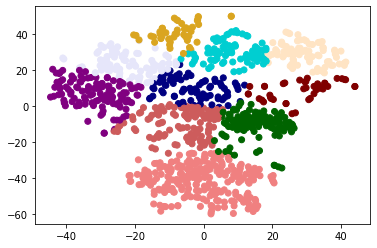

In [16]:
from sklearn.manifold import TSNE
# 使用tsne降维度
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
reduced_data = tsne.fit_transform(data)
labels=k_means(reduced_data,10,3,True,reduced_data)

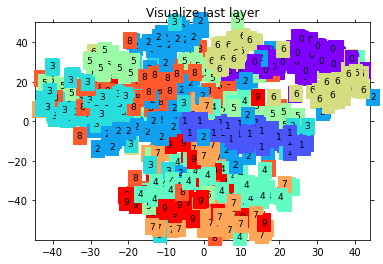

In [17]:
# 用真实数字标签看看效果咋样
pplot(reduced_data,test_y)
plot_with_labels(reduced_data,test_y.detach().numpy())

# 使用相似度矩阵来看聚类效果

In [18]:
# 根据标签排序
idx = np.argsort(labels)
data_ = data[idx]
data_ = data_.reshape(1000,1,-1)
reduced_data_ = reduced_data[idx]

In [19]:
# 计算相似度矩阵
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = np.zeros((1000,1000))
for i in range(1000):
    for j in range(1000):
        similarity_matrix[i][j]=euclid(reduced_data_[i],reduced_data_[j],2)

In [20]:
pic=similarity_matrix

In [21]:
for i in range(1000):
    for j in range(1000):
        pic[i][j]=-pic[i][j]
for i in range(1000):
        pic[i][i]=0

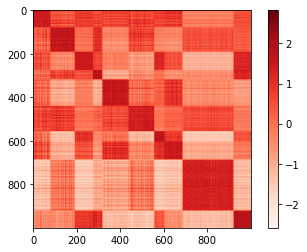

In [22]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
pic=scaler.fit_transform(pic)
plt.imshow(pic,cmap='Reds')
plt.colorbar()